In [1]:
dataset = 'lip'         #select from ['lip', 'atr', 'pascal']

In [3]:
#python -m ipykernel install --name schp --display-name "schp" --user
!pip install gdown

In [6]:
import gdown

if dataset == 'lip':
    url = 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH'
elif dataset == 'atr':
    url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
elif dataset == 'pascal':
    url = 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE'

output = 'final.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /home/jupyter/workspace/Self-Correction-Human-Parsing/final.pth
100%|██████████| 267M/267M [00:02<00:00, 101MB/s]  


'final.pth'

In [8]:
!pip install ninja

  Using cached ninja-1.11.1-py2.py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (145 kB)


In [9]:
! python3 simple_extractor.py --dataset 'lip' --model-restore 'final.pth' --input-dir 'inputs' --output-dir 'outputs'

Traceback (most recent call last):
  File "simple_extractor.py", line 25, in <module>
    from utils.transforms import transform_logits
  File "/home/jupyter/workspace/Self-Correction-Human-Parsing/utils/transforms.py", line 12, in <module>
    import cv2
ModuleNotFoundError: No module named 'cv2'


In [1]:
import torch
import tensorflow as tf
import numpy as np

In [2]:
import networks


In [3]:
model_std = networks.init_model('resnet101', num_classes=20, pretrained=None)
state_dict = torch.load("./final.pth")['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
model_std.load_state_dict(new_state_dict)
model_std.eval();

In [4]:
model_std._only_parse_output = True

In [5]:
inp = np.random.randn(1, 3, 473, 473).astype(np.float32)
inp_std = torch.from_numpy(inp)

In [6]:
out_std = model_std(inp_std).detach().numpy()

In [7]:
out_std.shape

(1, 20, 119, 119)

In [21]:
torch.onnx.export(model_std, inp_std, "./lip_473x473.onnx", export_params=True,
                  do_constant_folding=True, verbose=False, input_names=["input"], output_names=["output"],
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                  'output' : {0 : 'batch_size'}},
                  opset_version=11)

In [22]:
import onnx 
from onnx_tf.backend import prepare
from onnx2keras import onnx_to_keras


In [23]:
model_onnx = onnx.load("./lip_473x473.onnx")

In [24]:
onnx.checker.check_model(model_onnx)


In [25]:
print(onnx.helper.printable_graph(model_onnx.graph))

graph torch-jit-export (
  %input[FLOAT, batch_sizex3x473x473]
) initializers (
  %bn1.bias[FLOAT, 64]
  %bn1.running_mean[FLOAT, 64]
  %bn1.running_var[FLOAT, 64]
  %bn1.weight[FLOAT, 64]
  %bn2.bias[FLOAT, 64]
  %bn2.running_mean[FLOAT, 64]
  %bn2.running_var[FLOAT, 64]
  %bn2.weight[FLOAT, 64]
  %bn3.bias[FLOAT, 128]
  %bn3.running_mean[FLOAT, 128]
  %bn3.running_var[FLOAT, 128]
  %bn3.weight[FLOAT, 128]
  %context_encoding.bottleneck.0.weight[FLOAT, 512x4096x3x3]
  %context_encoding.bottleneck.1.bias[FLOAT, 512]
  %context_encoding.bottleneck.1.running_mean[FLOAT, 512]
  %context_encoding.bottleneck.1.running_var[FLOAT, 512]
  %context_encoding.bottleneck.1.weight[FLOAT, 512]
  %context_encoding.stages.0.1.weight[FLOAT, 512x2048x1x1]
  %context_encoding.stages.0.2.bias[FLOAT, 512]
  %context_encoding.stages.0.2.running_mean[FLOAT, 512]
  %context_encoding.stages.0.2.running_var[FLOAT, 512]
  %context_encoding.stages.0.2.weight[FLOAT, 512]
  %context_encoding.stages.1.1.weight[FLOAT

In [26]:
model_keras = onnx_to_keras(model_onnx, ['input'], verbose=False)


Unable to use `same` padding. Add ZeroPadding2D layer to fix shapes.
Unable to use `same` padding. Add ZeroPadding2D layer to fix shapes.
Unable to use `same` padding. Add ZeroPadding2D layer to fix shapes.
Unable to use `same` padding. Add ZeroPadding2D layer to fix shapes.


[None 512 1 1] [0] [2] [0]
[None 512 2 2] [0] [2] [0]
[None 512 3 3] [0] [2] [0]
[None 512 6 6] [0] [2] [0]
[None 256 30 30] [0] [2] [0]


In [14]:
out_keras=model_keras(inp)

In [18]:
model_keras.save("lip_473x473.pb")

INFO:tensorflow:Assets written to: lip_473x473.pb/assets


INFO:tensorflow:Assets written to: lip_473x473.pb/assets


In [15]:
out_keras.numpy().flatten()[:10]

array([5.5658617, 5.5622797, 5.9027095, 6.6051025, 6.774217 , 7.46483  ,
       6.358908 , 5.899672 , 6.060269 , 6.6109095], dtype=float32)

In [16]:
out_std.flatten()[:10]

array([5.5648184, 5.5598106, 5.898634 , 6.603047 , 6.7771273, 7.467044 ,
       6.35725  , 5.8973193, 6.0587196, 6.609029 ], dtype=float32)

In [3]:
import torch
class TestMod(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.nn.functional.interpolate(x, size=(14, 14), mode='bilinear', align_corners=True)
    

In [5]:
torch.onnx.export(TestMod(), torch.zeros((1, 3, 7, 7)), "./test.onnx", export_params=True,
                  do_constant_folding=True, verbose=False, input_names=["input"], output_names=["output"],
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                  'output' : {0 : 'batch_size'}}, opset_version=11)

In [20]:
model_tf = prepare(model_onnx)

In [21]:
out_tf = model_tf.run(inp).output

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [22]:
out_tf.shape

(1, 20, 45, 45)

In [23]:
np.allclose(out_std, out_tf, atol=1e-4)

True

In [24]:
out_tf.flatten()[0:10]

array([6.0851436, 4.8629365, 3.8546834, 3.7725825, 3.4321313, 2.7285113,
       3.4648833, 4.46503  , 3.6937575, 3.6977253], dtype=float32)

In [25]:
out_std.flatten()[0:10]

array([6.0851645, 4.8629513, 3.8547091, 3.7726018, 3.432149 , 2.7285213,
       3.4648895, 4.465031 , 3.6937554, 3.6977186], dtype=float32)

In [ ]:
model_tf.export_graph("./tf_lip_473x473.pb", )

In [40]:
model_saved = tf.saved_model.load("./lip_473x473.pb", tags=None)

In [26]:
out_saved = model_saved(inp_std)

In [28]:
out_saved.numpy().flatten()[0:10]

array([5.5658627, 5.5622826, 5.902707 , 6.605101 , 6.77422  , 7.4648323,
       6.3589096, 5.8996735, 6.060269 , 6.6109085], dtype=float32)

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa

/opt/conda/envs/schp/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [7]:
import cv2
import numpy as np

In [47]:
img = cv2.imread("./inputs/image.png")[..., ::-1]
#img = img[400:1200]

In [29]:
def get_affine_transform(input_h, input_w, output_h, output_w):
    aspect_ratio = output_w / output_h
    if input_h * aspect_ratio > input_w:
        scale = output_h / input_h
    else:
        scale = output_w / input_w

    center = np.array([input_w / 2., input_h / 2.])
    new_center = np.array([output_w / 2., output_h / 2.])
    translation = new_center - center * scale
    return np.array([[scale, 0., translation[0]],
                     [0.,    scale, translation[1]],
                     [0.,    0.,    1.]])


        

In [48]:
transform = get_affine_transform(img.shape[0], img.shape[1], 473, 473)
itransform = np.linalg.inv(transform)

In [31]:
import matplotlib.pyplot as plt

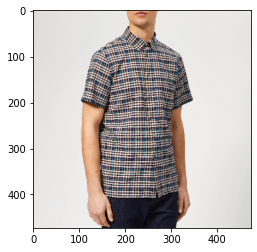

In [49]:
transformed_img = tfa.image.transform(img, itransform.flatten()[:8], output_shape=(473, 473)).numpy() / 255.0
plt.imshow(transformed_img)

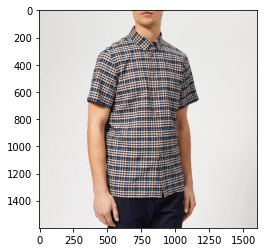

In [50]:
plt.imshow(img)

In [51]:
normalized_img = (transformed_img - np.array([0.406, 0.456, 0.485])) / np.array([0.225, 0.224, 0.229])

In [52]:
out_saved = model_saved(normalized_img.transpose(2, 0, 1)[None].astype(np.float32))

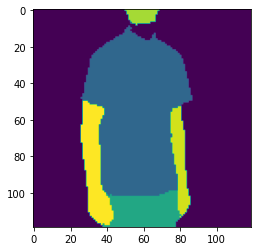

In [53]:
plt.imshow(tf.argmax(out_saved[0]).numpy())

In [56]:
from PIL import Image
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

In [55]:
output_img = Image.fromarray(np.asarray(tf.argmax(out_saved[0]).numpy(), dtype=np.uint8))

In [58]:
output_img.putpalette(get_palette(20))

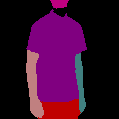

In [59]:
output_img

In [65]:
std_parse = cv2.imread('./inputs/std_graph.png')[..., 0]

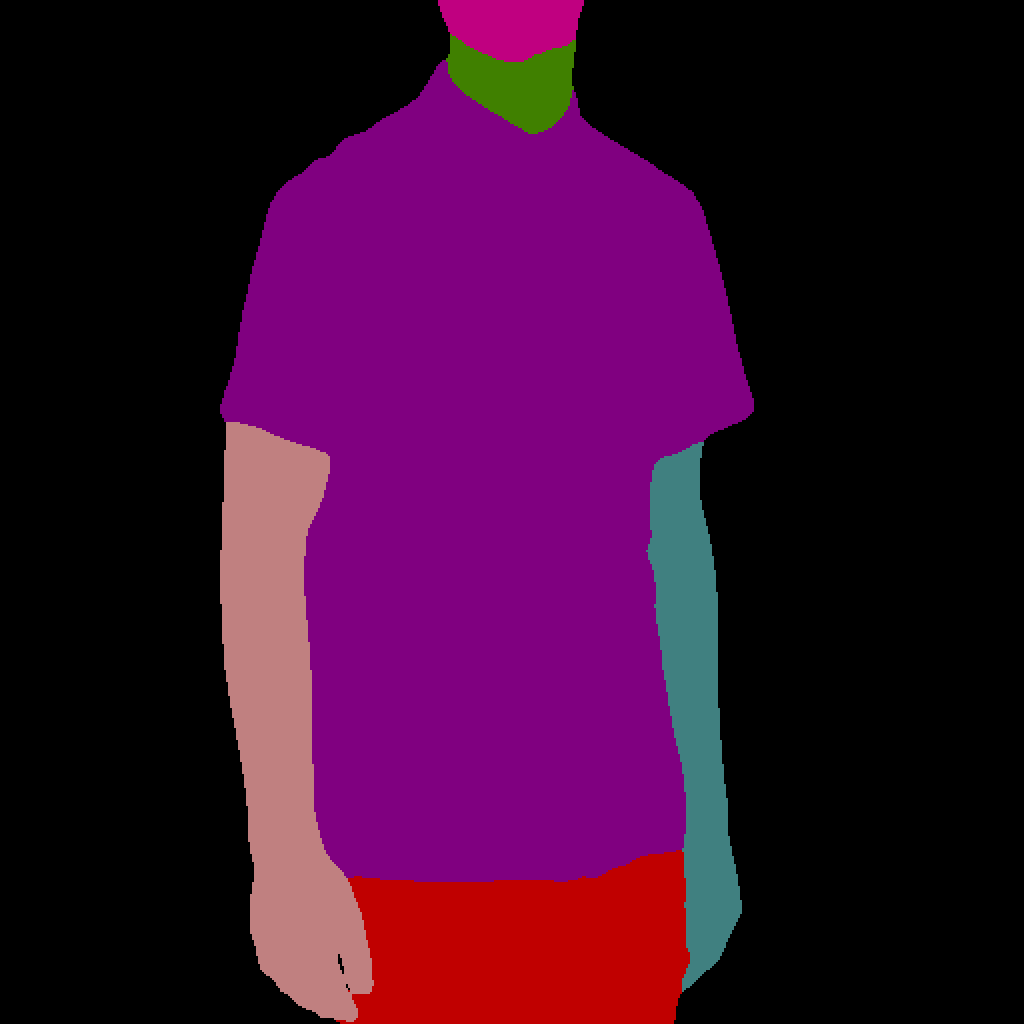

In [66]:
std_output_img = Image.fromarray(std_parse)
std_output_img.putpalette(get_palette(20))
std_output_img